# Time Series Regression

In [30]:
import warnings 
warnings.filterwarnings('ignore')

In [38]:
from time import time
from pathlib import Path
from tqdm import tqdm 

import numpy as np
from numpy.linalg import LinAlgError
import pandas as pd
import requests
import io

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.tree import  DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV

from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
import statsmodels.tsa.arima.model as tsa
from scipy.stats import probplot, moment
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

In [71]:
def transform_data(file_path): 
    
    '''
    This function transform the price into log return and output the weekly log return and price in a dataframe.
    '''

    outlier_cutoff = 0.01
    # read the data
    price = pd.read_csv(file_path)

    # print or inspect the DataFrame before renaming the columns
    print(price.head())

    # ask for the column names 
    column_names = input("Please enter the column names, separated by a comma: ").split(',')

    # strip any leading/trailing whitespace from the column names
    column_names = [name.strip() for name in column_names]

    # rename the columns 
    price.columns = column_names

    # transfer the date to date format 
    price['Date'] = pd.to_datetime(price['Date'])
    
    if (price['Price'].apply(type) == str).any():
        price['Price'] = price['Price'].str.replace(',', '', regex=True).astype(float)
    price.set_index('Date', inplace=True)

    # Resample to get the last business day's 'Close' price for each week.
    # 'W-FRI' denotes weeks ending on Friday.
    weekly_price = price['Price'].resample('W-FRI').last()

    # make the series a dataframe:
    weekly_price = pd.DataFrame(weekly_price)

    # Calculate log returns
    weekly_price['Log_Return'] = np.log(weekly_price["Price"]).diff().\
    pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                  upper=x.quantile(1-outlier_cutoff)))

    # The first entry will be NaN because there's no previous data to calculate a return from.
    # So, we remove the first entry
    weekly_price = weekly_price.dropna()

    return weekly_price

def plot_correlogram(x, lags=None, title=None):
    '''
    Plot the series, QQ plot, ACF, PACF
    '''
    lags = min(10, int(len(x)/5)) if lags is None else lags
    with sns.axes_style('whitegrid'):
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
        x.plot(ax=axes[0][0], title='Series(residuals)')
        x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
        q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
        stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
        axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
        probplot(x, plot=axes[0][1])
        mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
        s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
        
        axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
        
        plot_acf(x=x, lags=lags, ax=axes[1][0])
        plot_pacf(x, lags=lags, ax=axes[1][1])
        axes[1][0].set_xlabel('Lag')
        axes[1][1].set_xlabel('Lag')
        fig.suptitle(title, fontsize=14)
        sns.despine()
        fig.tight_layout()
        fig.subplots_adjust(top=.9)
        
def ARIMA_Model_Fit(series, p,d,q, title):
    '''
    Fit the ARIMA model and output the residual of the model 
    '''
    plot_correlogram(series, lags = 50, title = "Before Modeling: " + title)
    model_price = tsa.ARIMA(series,order=(p,d,q)).fit()
    print(model_price.summary())
    plot_correlogram(model_price.resid, lags = 50, title = "After Modeling: "+ title)
    return model_price.resid

def get_stock_data(ticker):
    close_label = "Close_" + ticker
    df = dataframes[ticker][['Date',close_label]].copy()
    df['Date'] = pd.to_datetime(df['Date'])

    df.columns = ['Date',"Asset_close"]

    df.set_index('Date', inplace=True)
    # Resample to get the last business day's 'Close' price for each week.
    # 'W-FRI' denotes weeks ending on Friday.
    weekly_df = df['Asset_close'].resample('W-FRI').last()

    weekly_df = pd.DataFrame(weekly_df)
    weekly_df['Log_Return'] = np.log(weekly_df["Asset_close"]).diff()

    # The first entry will be NaN because there's no previous data to calculate a return from.
    # So, we remove the first entry
    weekly_df = weekly_df.dropna()
    weekly_df['Lag1'] = weekly_df['Log_Return'].shift(1)
    weekly_df['Lag2'] = weekly_df['Log_Return'].shift(2)
    return weekly_df

def log_return_regression(feature_df):

    merged_df = weekly_future_price.merge(feature_df, how='left', left_index=True, right_index=True)
    clean_merged_df = merged_df.dropna()
    clean_df=clean_merged_df[["Log_Return_x","Lag1_x","Lag2_x","Lag3", "Lag1_y", "Lag2_y"]]
    clean_df.columns = ["Lithium_log", "Lithium(-1)", "Lithium(-2)", "Lithium(-3)", "Asset(-1)", "Asset(-2)"]
    clean_df.head()
    
    import statsmodels.api as sm

    # Define the dependent variable
    Y = clean_df["Lithium_log"]

    # Define the independent variables
    X = clean_df[["Lithium(-1)", "Lithium(-2)", "Lithium(-3)", "Asset(-1)", "Asset(-2)"]]

    # Add a constant to the independent variables matrix
    X = sm.add_constant(X)

    # Perform the OLS regression
    model = sm.OLS(Y, X)
    results = model.fit()

    # Print out the statistics including p-values
    print(results.summary())
    
    return results

## Weekly Future Price

In [32]:
weekly_future_price = transform_data("../Data/Lithium futures price.csv")

         Date       Open       High        Low      Close  Change %  Volume
0  2017-05-10 136,000.00 140,000.00 132,000.00 136,000.00      0.00       0
1  2017-05-11 136,000.00 140,000.00 132,000.00 136,000.00      0.00       0
2  2017-05-12 136,000.00 140,000.00 132,000.00 136,000.00      0.00       0
3  2017-05-15 136,000.00 140,000.00 132,000.00 136,000.00      0.00       0
4  2017-05-16 136,000.00 140,000.00 132,000.00 136,000.00      0.00       0


Please enter the column names, separated by a comma:  Date,Open,High,Low,Price,Change,Volume


In [42]:
weekly_future_price['Lag1'] = weekly_future_price['Log_Return'].shift(1)
weekly_future_price['Lag2'] = weekly_future_price['Log_Return'].shift(2)
weekly_future_price['Lag3'] = weekly_future_price['Log_Return'].shift(3)

In [77]:
weekly_future_price.head()

,Price,Log_Return,Lag1,Lag2,Lag3
Date,,,,,
2017-05-19,"141,000.00",0.04,NaN,NaN,NaN
2017-05-26,"141,000.00",0.00,0.04,NaN,NaN
2017-06-02,"143,000.00",0.01,0.00,0.04,NaN
2017-06-09,"144,500.00",0.01,0.01,0.00,0.04
2017-06-16,"144,500.00",0.00,0.01,0.01,0.00


                            OLS Regression Results                            
Dep. Variable:             Log_Return   R-squared:                       0.489
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     93.11
Date:                Fri, 04 Aug 2023   Prob (F-statistic):           2.63e-42
Time:                        01:12:34   Log-Likelihood:                 667.50
No. Observations:                 296   AIC:                            -1327.
Df Residuals:                     292   BIC:                            -1312.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.275      0.7

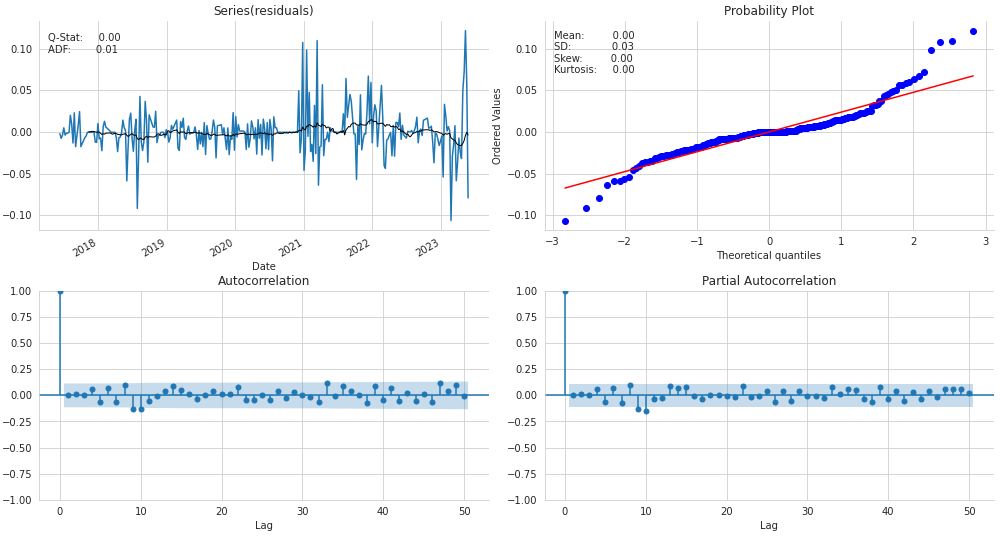

In [80]:
import statsmodels.api as sm

df = weekly_future_price.dropna().copy()

# Define the dependent variable
Y = df["Log_Return"]

# Define the independent variables
X = df[["Lag1", "Lag2", "Lag3"]]

# Add a constant to the independent variables matrix
X = sm.add_constant(X)

# Perform the OLS regression
model = sm.OLS(Y, X)
results = model.fit()

# Print out the statistics including p-values
print(results.summary())
plot_correlogram(results.resid, lags = 50)

## Mining Companies Stock Data (Log Return Lags) as Feature 

Repeated the work in Hardy's paper: 

Based on our data, only `Ganfeng's Asset (-1)` is significant, others are all insignificant.



In [14]:
mining_comp_list = ['SLI.US','ALB.US','SQM.US','1772.Hk','002466.SHE',
                    'LTHM.US','PLL.US','LAC.US','ORE.AU','GALXF.US','ENS.US','VUL.AU','CRE.V']

api_token = "5f3afd582bd7b4.95720069"
dataframes = {}

for stock in mining_comp_list:
    url = f"https://eodhistoricaldata.com/api/eod/{stock}?from=2005-01-01&to=2022-12-31&period=d&api_token={api_token}"

    response = requests.get(url)
    
    if response.status_code == 200:
        csv_data = io.StringIO(response.text)
        df = pd.read_csv(csv_data)

        df = df.rename(columns=lambda col_name: col_name if col_name == 'Date' else col_name + '_' + stock)

        dataframes[stock] = df
    else:
        print(f"Error: API request for {stock} failed with status code {response.status_code}")

        
all_dates = pd.concat([df['Date'] for df in dataframes.values()]).drop_duplicates().sort_values().reset_index(drop=True)
all_dates_df = pd.DataFrame({'Date': all_dates})


df_Limin = all_dates_df
for stock, df in dataframes.items():
    df_Limin = df_Limin.merge(df, on='Date', how='left')

In [86]:
def results(ticker):
    weekly_price = get_stock_data(ticker)
    results = log_return_regression(weekly_price)
    plot_correlogram(results.resid, lags = 50, title = ticker)


TICKER: SLI.US
                            OLS Regression Results                            
Dep. Variable:            Lithium_log   R-squared:                       0.489
Model:                            OLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                     50.51
Date:                Fri, 04 Aug 2023   Prob (F-statistic):           1.33e-36
Time:                        01:19:11   Log-Likelihood:                 646.93
No. Observations:                 270   AIC:                            -1282.
Df Residuals:                     264   BIC:                            -1260.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0005      0.001 

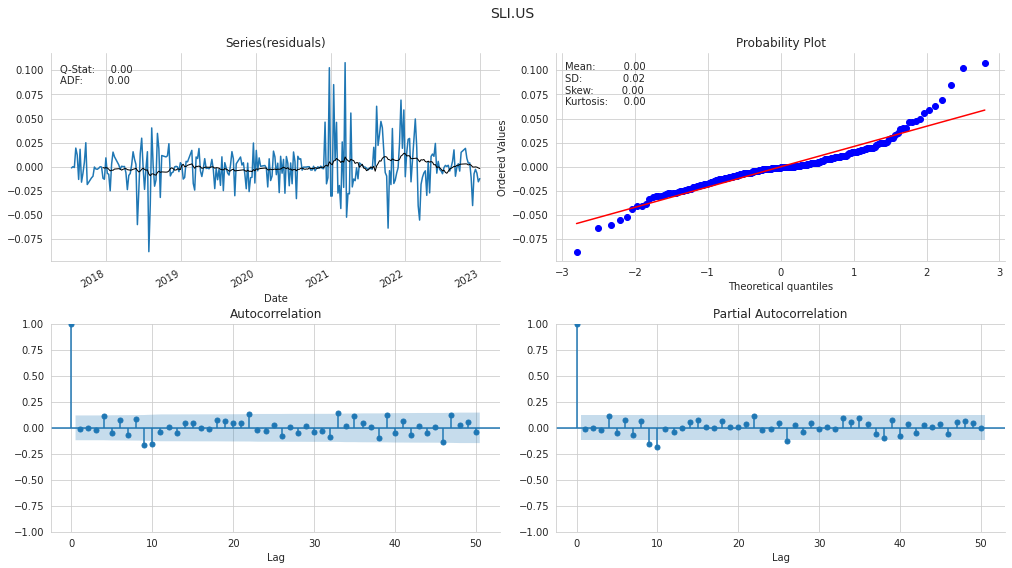

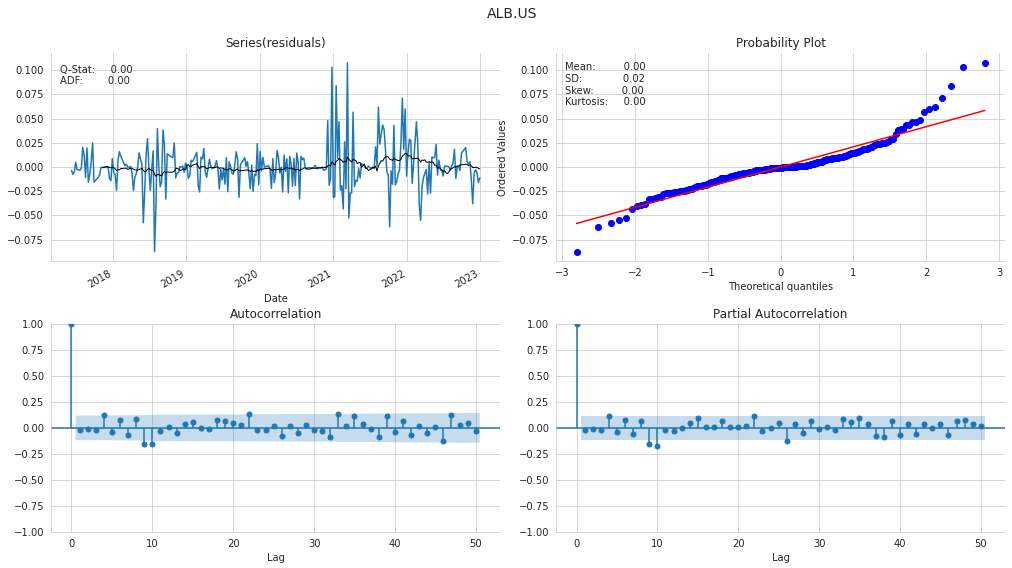

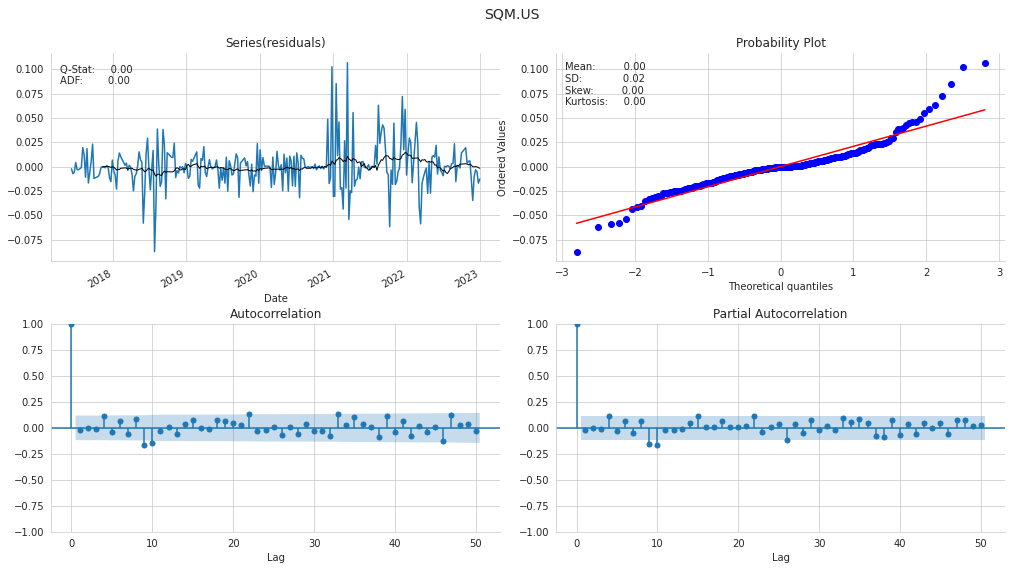

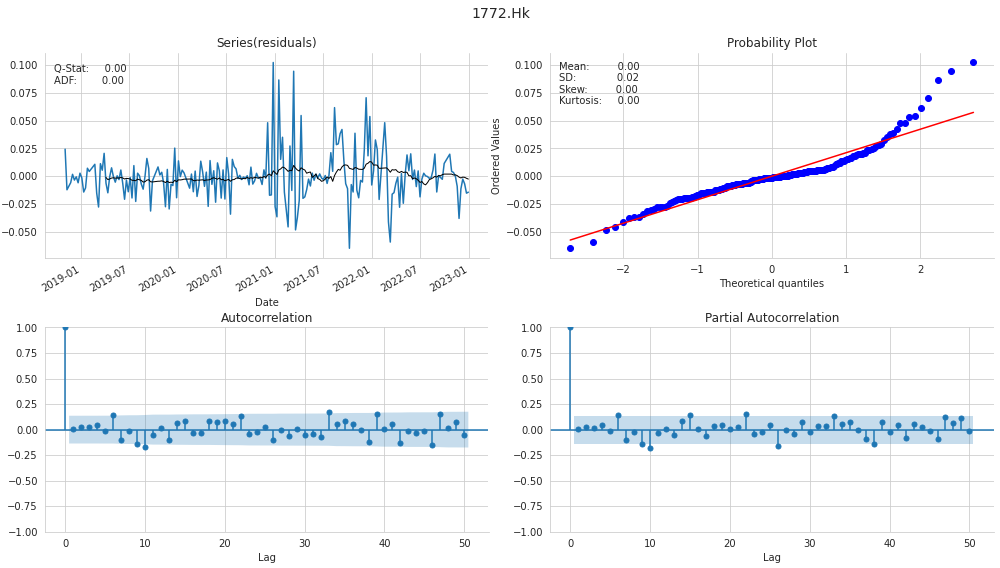

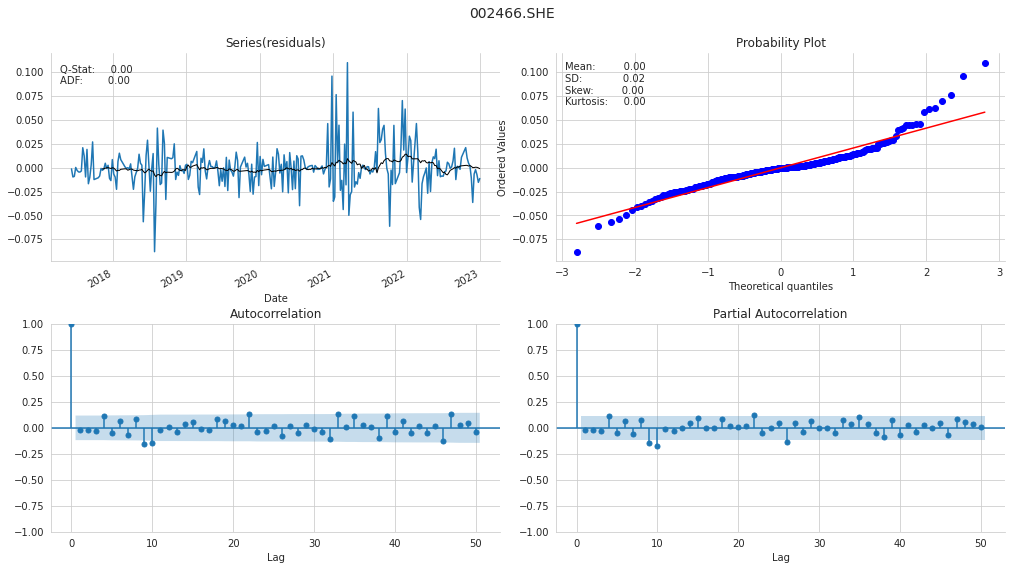

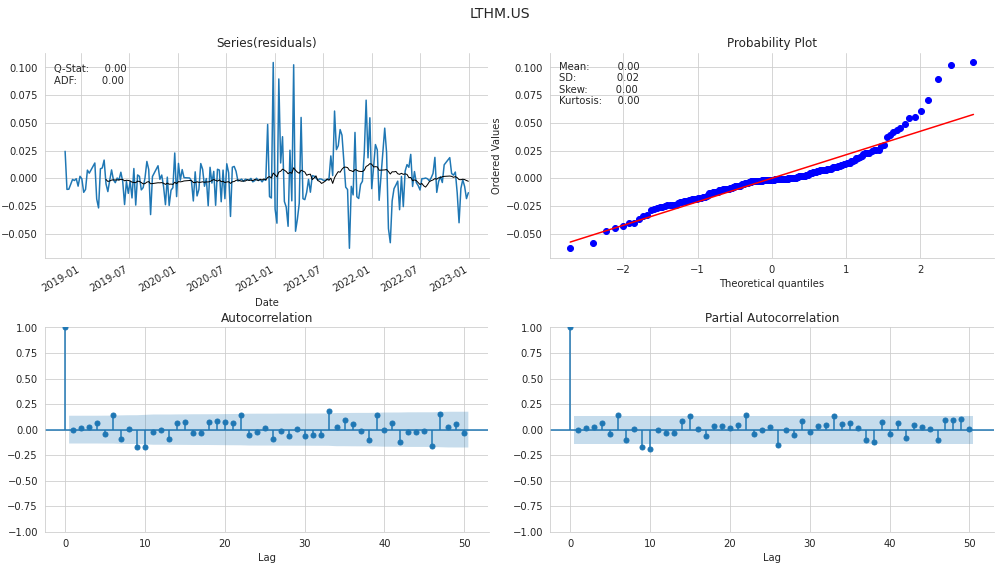

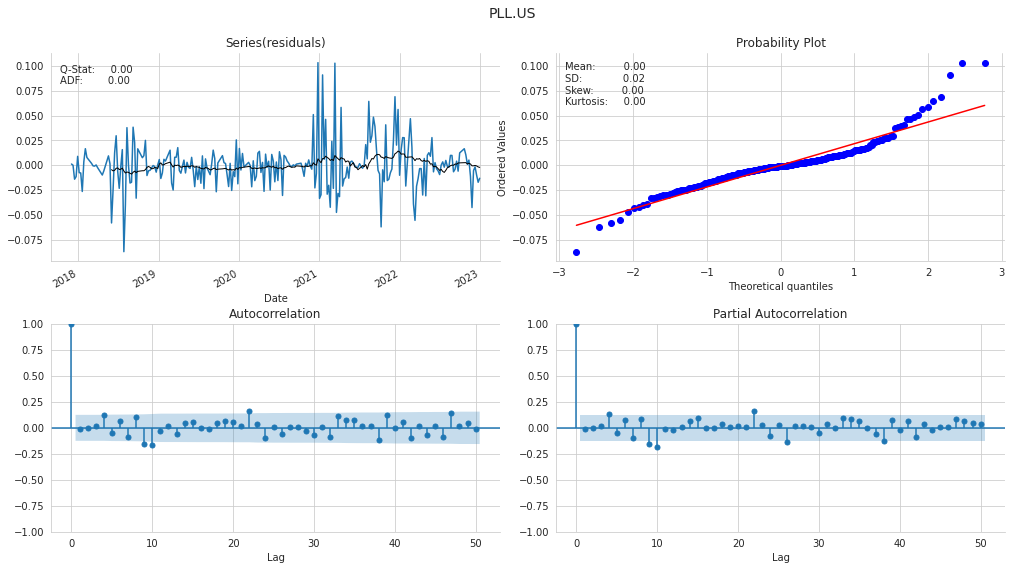

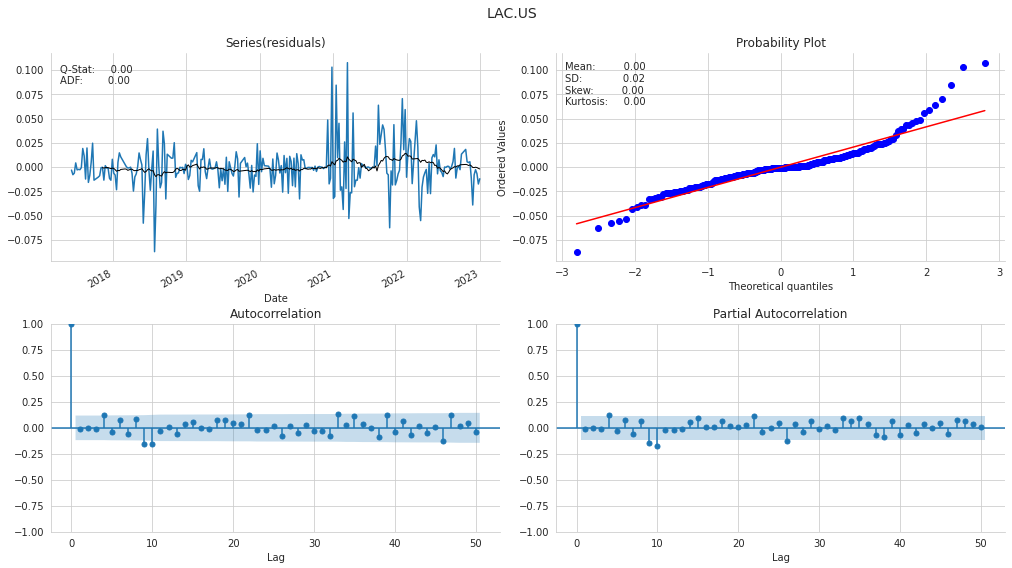

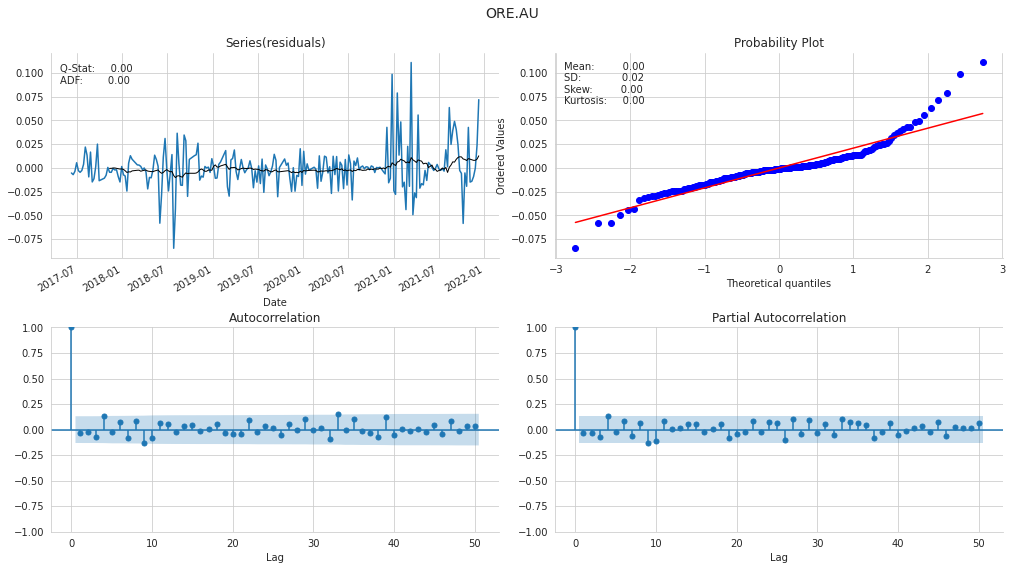

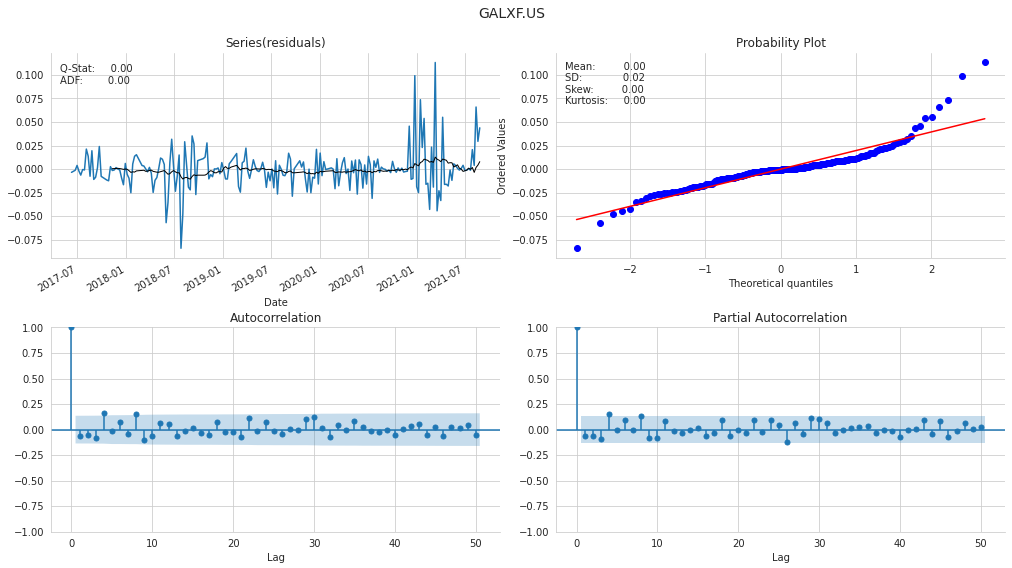

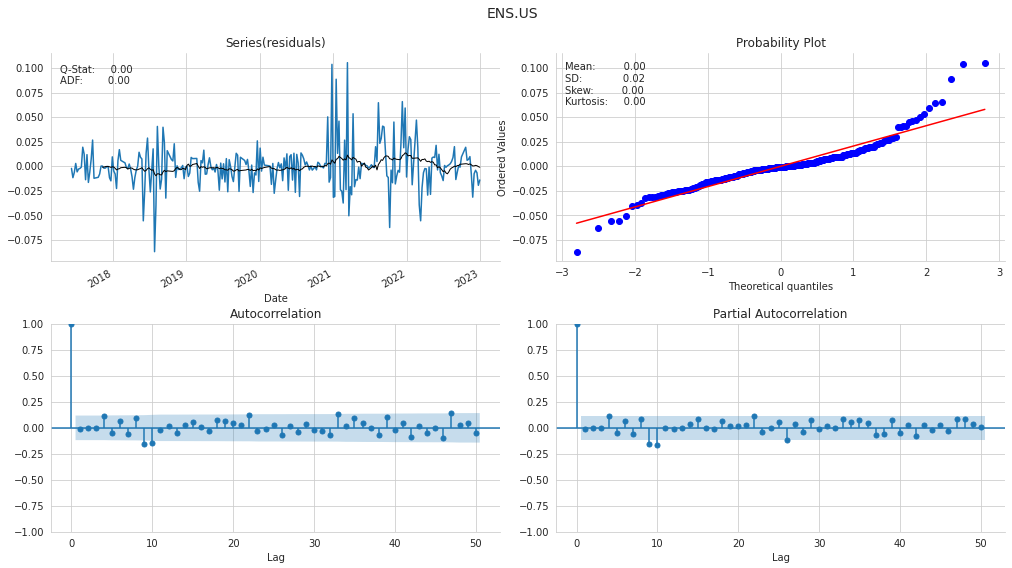

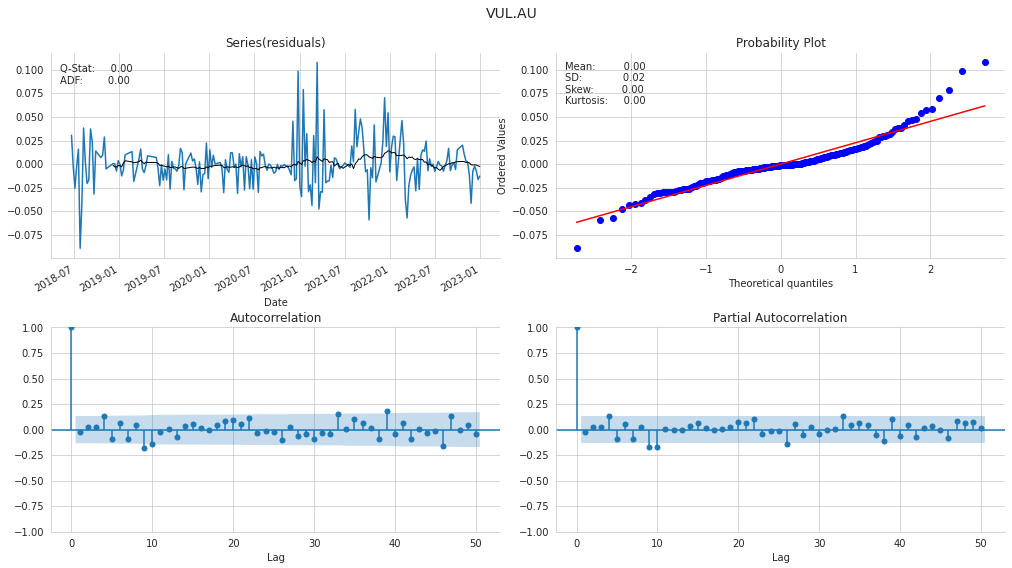

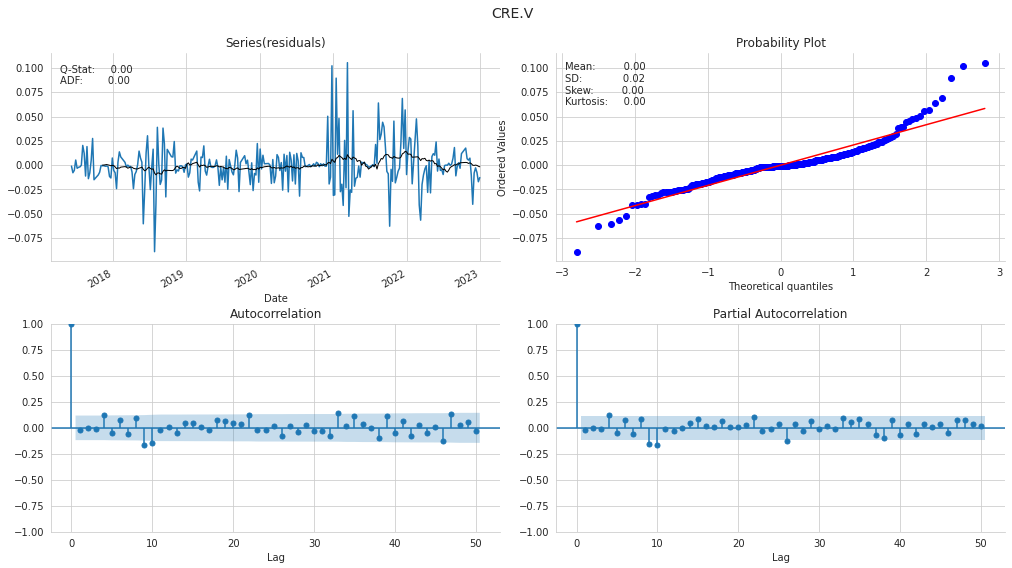

In [89]:
for ticker in mining_comp_list:
    print("========================\n")
    print(f"TICKER: {ticker}")
    
    results(ticker)